# Contrastive Loss

In [1]:
from pathlib import Path

METRICS_FILEPATH = "metrics.json"

MODEL_DIR = "models"
FIG_DIR = "figures"

# Create output directories if not exist
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

## Siamese Neural Networks

A popular form of Deep Learning models for estimating the similarity of input samples are **[Siamese Neural Networks](https://keras.io/examples/vision/siamese_contrastive)**.

They are made up of two (or more) Neural Networks which share identical weights.
If two samples are fed into a Siamese Neural Network and the two resulting embeddings are close in distance, these two samples can be considered to be similar (and vice versa).
The sharing of weights guarantees identical embeddings for two identical inputs and requires only a single backwards pass during training. 

## Contrastive Loss

The objective of Siamese Neural Networks is to maximize the distance between embeddings for dissimilar inputs while minimizing the distance between embeddings for similar ones.

A simple loss function for this objective is [**Contrastive Loss**](https://lilianweng.github.io/posts/2021-05-31-contrastive/#contrastive-loss).

Assuming our Siamese Neural Network is a function $f$ that takes two samples $x_i$ and $x_j$ that have corresponding labels $y_i$ and $y_j$, the Contrastive Loss function would be defined as follows:

$$L_{ctr}(x_i, x_j; y_i, y_j; f) = \{y_i = y_j\} \cdot {||f(x_i) - f(x_j)||}_2^2 + \{y_i \neq y_j\} \cdot \text{max}(0, m - ||f(x_i) - f(x_j)||_2^2)$$

where $m$ is a margin parameter that defines the desired distance between dissimilar examples. ($||x - z||_2^2$ denotes the squared Euclidean distance between the vectors $x$ and $z$)

Intuitively we can see, that the loss function trains our Siamese Network to output $0$ for similar and $m$ for dissimilar inputs.

## One-Shot Classification using Contrastive Loss

Let's train our Sign Language Recognition model using Contrastive Loss.

Since our reasoning for One-Shot Learning was to apply our model to previously unseen signs, we'll exclude the test signs from the training data entirely.

For Siamese Neural Networks, our data should be present in random pairs of matching and non-matching samples. The labels now represent the distance between samples ($0$ if matching, $m=1$ if non-matching):

In [2]:
from core.dataset import DGSAlphabet

TEST_LABELS = ['u', 'v', 'w', 'x', 'y']

# Import the dataset
dataset = DGSAlphabet()
pair_dataset = dataset.load_pairs(
    margin=1,
    exclusive_test_labels=TEST_LABELS
)

x_train_1 = pair_dataset.x_train_1
x_train_2 = pair_dataset.x_train_2
labels_train = pair_dataset.y_train


x_test_1 = pair_dataset.x_test_1
x_test_2 = pair_dataset.x_test_2
labels_test = pair_dataset.y_test

For the Siamese Neural Network we want to re-use the original model's architecture, just twice with shared weights.

To give the model the best shot at success we'll use Keras Tuner once again:

In [3]:
from core.util import new_SNN_builder
from core.loss import new_contrastive_loss
from core.distance import euclidean_distance

# Create model builder for Keras Tuner
build_model = new_SNN_builder(
    mode="siamese",
    loss=new_contrastive_loss(margin=1),
    distance=euclidean_distance
)

In [4]:
# Tuning Hyperparameters
# https://keras.io/api/keras_tuner/tuners/hyperband
MAX_EPOCHS = 150
FACTOR = 3
HYPERBAND_ITERATIONS = 1
SEED = 42
VAL_SPLIT = 0.2

# Where to save tuner checkpoints
TUNER_DIR = "tuner"
PROJECT = "contrastive_loss"

In [5]:
import keras_tuner

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=MAX_EPOCHS,
    factor=FACTOR,
    hyperband_iterations=HYPERBAND_ITERATIONS,
    seed=SEED,
    directory=TUNER_DIR,
    project_name=PROJECT
)

tuner.search_space_summary()

Reloading Tuner from tuner/contrastive_loss/tuner0.json
Search space summary
Default search space size: 8
dense_count (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
dense_base (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
encoder_dropout (Boolean)
{'default': False, 'conditions': []}
siamese_bn (Boolean)
{'default': False, 'conditions': []}
start_lr (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.001, 'step': 5e-05, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.99, 'conditions': [], 'min_value': 0.99, 'max_value': 0.999, 'step': 0.001, 'sampling': 'linear'}
epsilon (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.001, 'sampling': 'linear'}


In [6]:
from core.util import new_default_callbacks, TunerHistoryCallback

# Reduce learning rate if no improvement is made
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_loss",
    mode="min",
    lr_reduce_factor=0.2,
    lr_reduce_patience=5,
    verbose=1
)

# Keep track of histories for every tuner trial
tuner_history_cb = TunerHistoryCallback(tuner)

Loading history from JSON tuner/contrastive_loss/history.json


In [7]:
tuner.search(
    [x_train_1, x_train_2], 
    labels_train,
    validation_split=VAL_SPLIT,
    callbacks=[reduce_lr, early_stop, tuner_history_cb]
)

In [8]:
tuner.results_summary()

Results summary
Results in tuner/contrastive_loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0144 summary
Hyperparameters:
dense_count: 10
dense_base: 24
encoder_dropout: False
siamese_bn: True
start_lr: 0.00075
beta_1: 0.7
beta_2: 0.998
epsilon: 0.008
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 0.019386345520615578

Trial 0203 summary
Hyperparameters:
dense_count: 8
dense_base: 64
encoder_dropout: False
siamese_bn: True
start_lr: 0.00015000000000000001
beta_1: 0.7
beta_2: 0.995
epsilon: 0.001
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0199
Score: 0.019923098385334015

Trial 0142 summary
Hyperparameters:
dense_count: 10
dense_base: 24
encoder_dropout: False
siamese_bn: True
start_lr: 0.00075
beta_1: 0.7
beta_2: 0.998
epsilon: 0.008
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0131
Score: 0.02015668712556362



Since we again want convenient access to the model's encoder part, we'll re-instantiate the model with the best architecture and transfer the best model's weights:

In [9]:
# Get history of best model training
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model_history = tuner_history_cb.get_trial_history(
    best_trial.trial_id
)

# Get weights of best model
best_model = tuner.get_best_models(1)[0]
best_weights = best_model.weights

# Alternatively, if missing tuning checkpoints:
# Load model directly and skip history plots
# from keras.saving import load_model
# best_model = load_model(f"{MODEL_DIR}/contrastive_loss.keras")
# best_weights = best_model.weights

# Re-create best architecture
best_hyper_params = tuner.get_best_hyperparameters(1)[0]
snn_encoder, siamese_snn = build_model(best_hyper_params, get_encoder=True)
siamese_snn.set_weights(best_weights)

siamese_snn.summary()
snn_encoder.summary()

Model: "SNN_10_siamese"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 SNN_10_encoder (Functional  (None, 24)                   1148921   ['input_3[0][0]',             
 )                                                        4          'input_4[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 1)                    0         ['SNN_10_encoder[

Let's save the best model and take a look at its training history:

In [10]:
siamese_snn.save(f"{MODEL_DIR}/contrastive_loss.keras")

Our model now takes about twice the number of epochs to converge, but we seem reach a decently low validation loss:

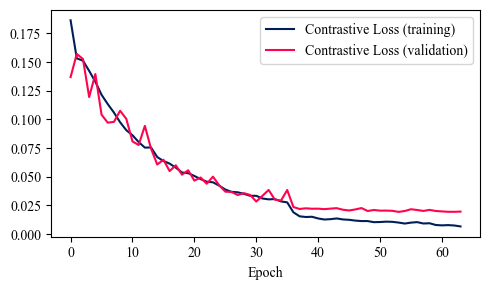

In [11]:
from core.viz import visualize_history

visualize_history(
    best_model_history,
    ["loss"],
    "Contrastive Loss",
    f"{FIG_DIR}/contrastive_loss_history.svg"
)

Our model's loss also seems to remain quite low for entirely unseen signs:

In [12]:
# And evaluate the model on test data
loss = siamese_snn.evaluate([x_test_1, x_test_2], labels_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.0997


This leads us to our model's evaluation in terms of One-Shot classification.

For this, we'll only use the encoder portion of the model in a non-siamese configuration, meaning we no longer need pair-wise data:

In [13]:
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)

x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

As the main evaluation metric we'll use the so called "[n-way accuracy](https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463)":

We randomly choose $n$ samples of different classes as our support set. All other samples form the query set.
Each sample from the query set will be compared to every sample of the support set. The support set sample's embedding producing the smallest distance to the query sample's embedding will be chosen as a prediction.

To simplify things we set $n=5$, meaning our support set encompasses all classes from the test set.

Since the model's ability to predict correct classes might depend on the quality of the randomly chosen support samples, we perform multiple iterations of the same evaluation process where different support samples are chosen every time.

While obviously lower than with conventional classification, our accuracy score is still fairly respectable:


In [14]:
from core.util import evaluate_n_way_accuracy


y_true, y_pred, mean_acc, min_acc, max_acc, std = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=1,
    iterations=10
)

print(
    f"Mean 5-way accuracy: {mean_acc}\n"
    f"Min 5-way accuracy: {min_acc}\n"
    f"Max 5-way accuracy: {max_acc}\n"
    f"5-way accuracy std.: {std}"
)

Mean 5-way accuracy: 0.7599367088607595
Min 5-way accuracy: 0.6240506329113924
Max 5-way accuracy: 0.8417721518987342
5-way accuracy std.: 0.05732587730633416


However, looking at the confusion matrix, we can see a worrying pattern:

The model performs very well on "easy" pairings while it is little better than random for "hard" pairings:

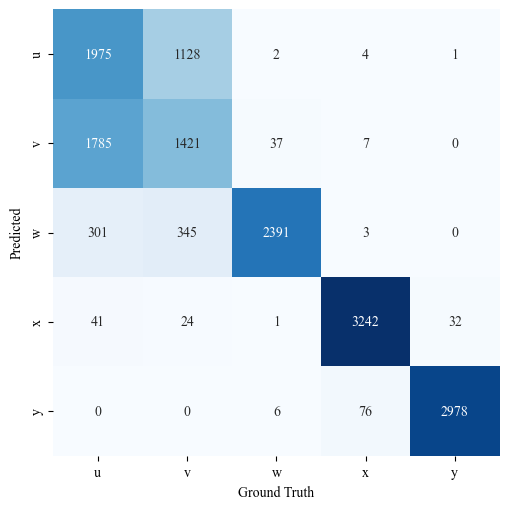

In [15]:
from core.viz import visualize_confusion_matrix

unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(
    y_true, y_pred, 
    str_test_labels,
    f"{FIG_DIR}/contrastive_loss_conf_matrix.svg"
)

As means to improve our model's One-Shot performance on these hard classes, we might use so called "[prototypes](https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463)"" in our support set.

Instead of comparing against a single random support embedding, we'll average $k$ random embeddings to form a support prototype.
This could potentially help reduce the negative effects from outliers being chosen as supports.

As we can see, prototypes significantly improve the accuracy score and reduce the accuracy variance across iterations. There also seems to be strongly diminishing returns for $k > 15$:

In [16]:
from core.util import save_n_way_k_prototype_accuracy

save_n_way_k_prototype_accuracy(
    x_test,
    y_test,
    snn_encoder,
    METRICS_FILEPATH,
    "Contrastive Loss"
)

Mean 5-way accuracy (k-prototype = 1): 0.7599367088607595, std: 0.05732587730633416
Mean 5-way accuracy (k-prototype = 3): 0.8101910828025478, std: 0.04081306799953002
Mean 5-way accuracy (k-prototype = 5): 0.8270512820512821, std: 0.03227715284316058
Mean 5-way accuracy (k-prototype = 10): 0.8363517915309447, std: 0.020032546807535277
Mean 5-way accuracy (k-prototype = 15): 0.8418543046357616, std: 0.022593945697381417
Mean 5-way accuracy (k-prototype = 20): 0.8488215488215488, std: 0.020388032524432692
Mean 5-way accuracy (k-prototype = 50): 0.8512359550561797, std: 0.009836435338534535
Mean 5-way accuracy (k-prototype = 75): 0.858595041322314, std: 0.010043617735799535
Mean 5-way accuracy (k-prototype = 100): 0.864700460829493, std: 0.012595406677129217
Saved Contrastive Loss metrics to metrics.json


Despite this improvement, the model still seems to struggle with "u" and "v" classes:

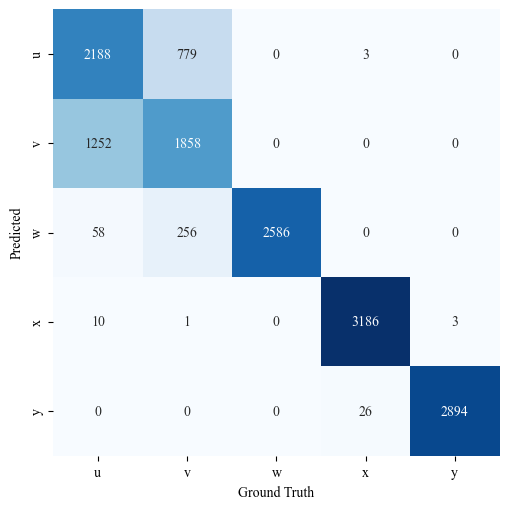

In [17]:
y_true, y_pred, _, _, _, _ = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=15,
    iterations=10
)

visualize_confusion_matrix(
    y_true, y_pred, 
    str_test_labels,
    f"{FIG_DIR}/contrastive_loss_conf_matrix_k15.svg"
)

We can also take a look at the embeddings our contrastive model produces.

In [18]:
# And get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

50/50 [==============================] - 0s 7ms/step


In [19]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1585 samples in 0.000s...
[t-SNE] Computed neighbors for 1585 samples in 0.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1585
[t-SNE] Computed conditional probabilities for sample 1585 / 1585
[t-SNE] Mean sigma: 1.210964
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.046364
[t-SNE] KL divergence after 1000 iterations: 0.388464


Again, the weaknesses shown in the confusion matrix are repeated in the embeddings:

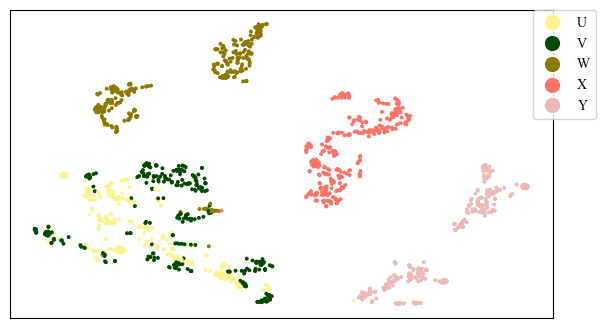

In [20]:
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
visualize_embeddings(
    reduced_embeddings,
    y_test,
    label_map,
    f"{FIG_DIR}/contrastive_loss_embeddings.svg"
)

Using Contrastive Loss, our model only had to compare either similar or dissimilar pairings at one time.

Maybe comparing between similar and dissimilar samples at once using [Triplet Loss](./triplet_loss.ipynb) might improve our model's One-Shot classification performance?